In [1]:
import os
import pandas as pd
#from sep_util import read_file
import utm
import numpy as np
import h5py
import time
import tqdm
import glob


# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
# %matplotlib inline
params = {
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 18, # fontsize for x and y labels (was 10)
    'axes.titlesize': 18,
    'font.size': 18,
    'legend.fontsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'text.usetex':False,
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white'
}
matplotlib.rcParams.update(params)

In [2]:
# load the DAS channel location
DAS_info = np.genfromtxt('/kuafu/DASdata/DASinfo/DAS_ChannelLocation/DAS_Olancha_Plexus.txt')

DAS_channel_num = DAS_info.shape[0]
DAS_index = DAS_info[:, 0].astype('int')
DAS_lon = DAS_info[:, 1]
DAS_lat = DAS_info[:, 2]

### First read the catalog, the catalog is from STP with command:

```bash
EVENT -mag 2.0 8.0 -lat 33.65 37.65 -lon -119.72 -115.72 -t0 2019/7/10,18:00:00 2021/6/5,18:00:00 -f Ridgecrest_das_catalog_M2_M8.txt
```

In [3]:
print(os.getcwd())
catalog_file =  '/home/yinjx/notebooks/Ridgecrest/Ridgecrest_das_catalog_M2_M8.txt'
catalog = pd.read_csv(catalog_file, sep='\s+', header=None, skipfooter=1, engine='python')
catalog

/home/yinjx/notebooks/Ridgecrest


,0,1,2,3,4,5,6,7,8,9
0,38521207,eq,l,"2019/07/10,18:00:01.250",35.7753,-117.6033,7.59,2.26,l,1.0
1,38521231,eq,l,"2019/07/10,18:01:27.840",35.6733,-117.5210,5.71,2.37,l,1.0
2,38521351,eq,l,"2019/07/10,18:11:09.650",35.7067,-117.5282,9.24,2.02,l,1.0
3,38521591,eq,l,"2019/07/10,18:30:10.250",35.6533,-117.5022,7.97,2.42,l,1.0
4,38521775,eq,l,"2019/07/10,18:44:42.310",35.6738,-117.5278,8.65,2.17,l,1.0
...,...,...,...,...,...,...,...,...,...,...
4409,39914032,eq,l,"2021/06/02,07:44:21.310",35.9512,-117.3327,3.37,2.16,l,1.0
4410,39915440,eq,l,"2021/06/03,04:48:33.690",34.3058,-116.9277,8.38,2.27,l,1.0
4411,39915912,eq,l,"2021/06/03,15:52:48.420",33.9922,-117.0828,16.10,2.13,l,1.0
4412,39916960,eq,l,"2021/06/04,12:18:09.310",33.9017,-116.1048,9.01,2.49,l,1.0


### Load the picked peak ampliutde

In [4]:
# Load the peak amplitude results
import pandas as pd
import numpy as np

results_output_dir = '/home/yinjx/kuafu/Olancha_Plexus/Olancha_strain_rate_scaling'

# directory to store the fitted results
regression_results_dir = results_output_dir + '/regression_results_smf'
if not os.path.exists(regression_results_dir):
    os.mkdir(regression_results_dir)

In [6]:
das_pick_file_name = results_output_dir + '/peak_amplitude_M3+.csv'
peak_amplitude_df = pd.read_csv(das_pick_file_name)

peak_amplitude_df

,event_id,magnitude,distance_in_km,peak_P,peak_S,peak_P_strain,peak_S_strain,channel_id
0,39271783.0,3.55,23.992769,3241.643799,10912.948242,40555.190335,1.713224e+06,1.0
1,39271783.0,3.55,23.991433,1799.253418,2443.448486,32861.372461,6.416178e+04,2.0
2,39271783.0,3.55,23.990204,1575.085693,2445.881348,34331.384903,5.781252e+04,3.0
3,39271783.0,3.55,23.982242,1274.975098,2643.548584,27070.025524,5.583066e+04,4.0
4,39271783.0,3.55,23.969897,666.307190,982.888794,14400.507230,3.240945e+04,5.0
...,...,...,...,...,...,...,...,...
137495,39552143.0,3.60,91.217787,1867.272217,6815.295410,41461.371355,3.237978e+05,6246.0
137496,39552143.0,3.60,91.226474,1272.815063,7837.130371,42288.935718,3.042178e+05,6247.0
137497,39552143.0,3.60,91.234311,1384.278687,6101.903320,49550.029544,3.159685e+05,6248.0
137498,39552143.0,3.60,91.242149,1047.497803,6153.563965,41760.434676,3.404253e+05,6249.0


### Find event with the selected event ID using .isin()

In [7]:
event_id_selected = np.unique(peak_amplitude_df['event_id'])
catalog_select = catalog[catalog[0].isin(event_id_selected)]
num_events = catalog_select.shape[0]
catalog_select

,0,1,2,3,4,5,6,7,8,9
3561,39271783,eq,l,"2020/06/29,01:55:49.010",36.4833,-117.9757,7.16,3.55,l,1.0
3579,39276943,eq,r,"2020/07/02,18:49:41.090",37.4650,-118.7310,2.82,3.44,l,0.5
3625,39292639,eq,l,"2020/07/14,12:15:18.870",36.4538,-117.9870,3.70,3.58,w,1.0
3641,38599882,eq,l,"2020/07/20,22:01:53.080",34.9318,-119.0378,13.57,3.60,l,1.0
3644,38603762,eq,l,"2020/07/23,00:29:26.230",36.4477,-117.9892,4.09,3.67,w,1.0
3652,38605954,eq,l,"2020/07/24,07:05:13.560",36.4452,-117.9595,7.59,3.74,w,1.0
3751,39587168,eq,l,"2020/08/21,08:20:08.360",35.6442,-117.4598,6.22,3.60,w,1.0
3776,39368535,eq,l,"2020/09/02,16:18:31.660",36.0378,-117.7732,1.88,3.45,w,1.0
3777,38675290,eq,l,"2020/09/04,11:39:18.200",36.4662,-117.9617,7.02,3.00,l,1.0
3781,38676562,eq,l,"2020/09/05,03:14:58.250",35.6733,-117.4647,8.82,3.04,l,1.0


### Show a simple map for the DAS array and events

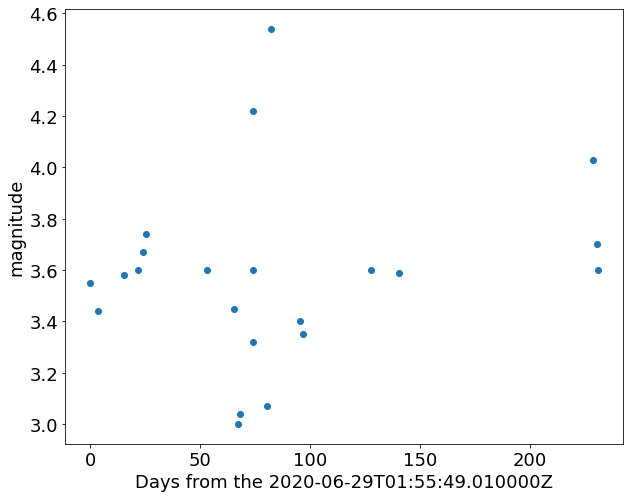

In [8]:
# Quickly look at the time variation of selected earthquakes
import obspy

time_list = [obspy.UTCDateTime(time) for time in catalog_select[3]]
time_span = np.array([time-time_list[0] for time in time_list])
time_span_days = time_span/3600/24

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(time_span_days, catalog_select[7], 'o')
ax.set_xlabel(f'Days from the {time_list[0]}')
ax.set_ylabel('magnitude')
plt.savefig(results_output_dir + '/time_variation_selected_earthquakes.png', bbox_inches='tight')

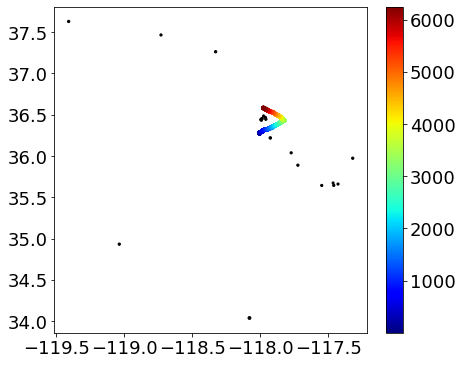

In [9]:
# Find the selected events
fig, ax = plt.subplots(figsize=(7, 6))
cmp = ax.scatter(DAS_lon, DAS_lat, s=10, c=DAS_index, cmap='jet')
ax.scatter(catalog_select[5], catalog_select[4], s=10**(catalog_select[7]/5), c='k')
fig.colorbar(cmp)
plt.savefig(results_output_dir + '/map_of_earthquakes_not_grouped.png', bbox_inches='tight')

### Flatten all the measured results.

In [10]:
def extract_flatten_data(peak_amplitude_df):
    peak_ampliutde_P_all_flatten = np.array(peak_amplitude_df['peak_P'])
    peak_ampliutde_S_all_flatten = np.array(peak_amplitude_df['peak_S'])
    distance_all_km_flatten = np.array(peak_amplitude_df['distance_in_km'])
    magnitude_all_flatten = np.array(peak_amplitude_df['magnitude'])
    event_id_all_flatten = np.array(peak_amplitude_df['event_id']).astype('int')
    
    return peak_ampliutde_P_all_flatten, peak_ampliutde_S_all_flatten, distance_all_km_flatten, magnitude_all_flatten, event_id_all_flatten

In [11]:
peak_ampliutde_P_all_flatten, peak_ampliutde_S_all_flatten, \
distance_all_km_flatten, magnitude_all_flatten, event_id_all_flatten = extract_flatten_data(peak_amplitude_df)

### Quickly check the data coverage and distributions

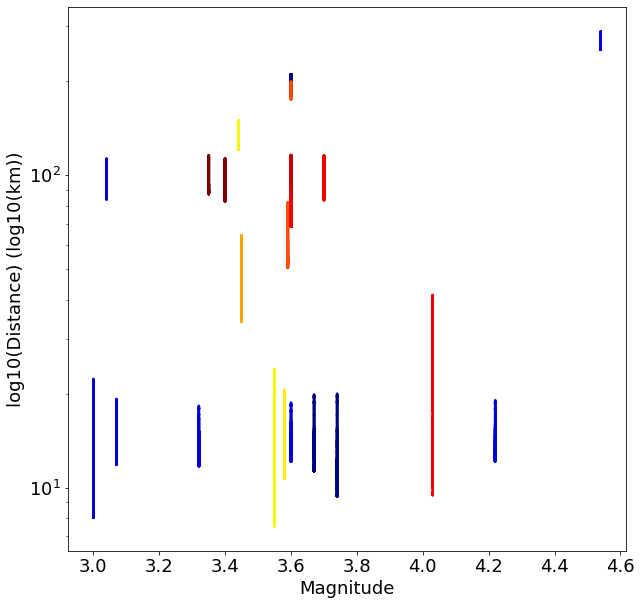

In [12]:
# Look at the data coverage in magnitude-distance space
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(magnitude_all_flatten, distance_all_km_flatten, marker='o', s=3, c=np.sqrt(event_id_all_flatten), cmap='jet', alpha=0.1)

ax.set_yscale('log')
#ax[1].set_xscale('log')
ax.set_xlabel('Magnitude')
ax.set_ylabel('log10(Distance) (log10(km))')
plt.savefig(results_output_dir + '/magnitude_distance_distribution.png', bbox_inches='tight')

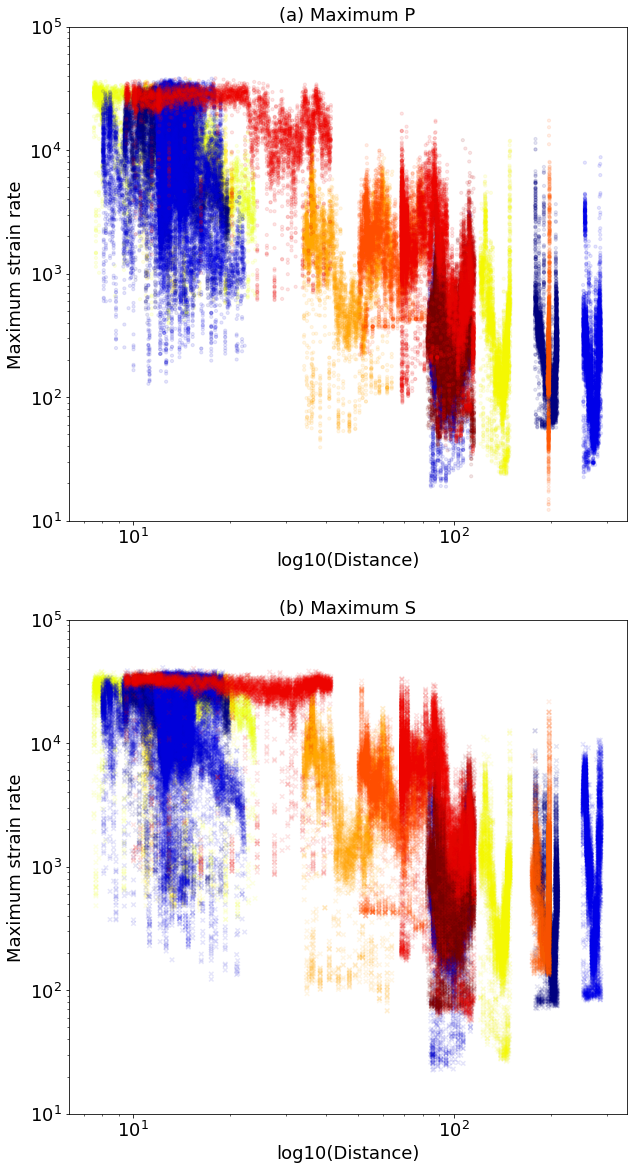

In [12]:
# Look at the rough variation of measured strain rate with distance
fig, ax = plt.subplots(2, 1, figsize=(10, 20), sharex=True, sharey=True)
ax[0].scatter(distance_all_km_flatten, peak_ampliutde_P_all_flatten, marker='o', s=10, c=np.sqrt(event_id_all_flatten), cmap='jet', alpha=0.1)
ax[1].scatter(distance_all_km_flatten, peak_ampliutde_S_all_flatten, marker='x', s=20, c=np.sqrt(event_id_all_flatten), cmap='jet', alpha=0.1)

ax[1].set_yscale('log')
ax[1].set_xscale('log')


ax[0].set_ylabel('Maximum strain rate')
ax[0].set_xlabel('log10(Distance)')
ax[0].set_title('(a) Maximum P')
ax[0].xaxis.set_tick_params(which='both',labelbottom=True)
ax[1].set_title('(b) Maximum S')
ax[1].set_xlabel('log10(Distance)')
ax[1].set_ylabel('Maximum strain rate')
ax[1].set_ylim(10, 1e5)

plt.savefig(results_output_dir + '/peak_strain_rate_vs_distance.png', bbox_inches='tight')

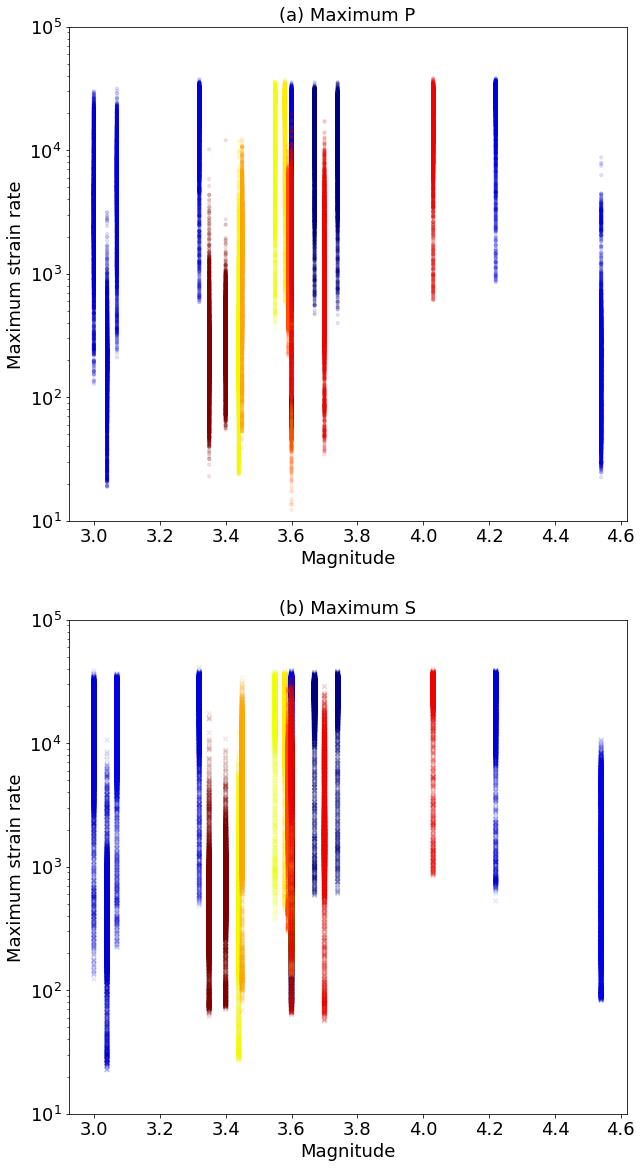

In [13]:
# Look at the rough variation of measured strain rate with magnitude

fig, ax = plt.subplots(2, 1, figsize=(10, 20), sharex=True, sharey=True)
ax[0].scatter(magnitude_all_flatten, peak_ampliutde_P_all_flatten, marker='o', s=10, c=np.sqrt(event_id_all_flatten), cmap='jet', alpha=0.1)
ax[1].scatter(magnitude_all_flatten, peak_ampliutde_S_all_flatten, marker='x', s=20, c=np.sqrt(event_id_all_flatten), cmap='jet', alpha=0.1)

ax[1].set_yscale('log')

ax[0].set_ylabel('Maximum strain rate')
ax[0].set_xlabel('Magnitude')
ax[0].set_title('(a) Maximum P')
ax[0].xaxis.set_tick_params(which='both',labelbottom=True)
ax[1].set_title('(b) Maximum S')
ax[1].set_xlabel('Magnitude')
ax[1].set_ylabel('Maximum strain rate')
ax[1].set_ylim(10, 1e5)

plt.savefig(results_output_dir + '/peak_strain_rate_vs_magnitude.png', bbox_inches='tight')

Median: 0.5068720241445064


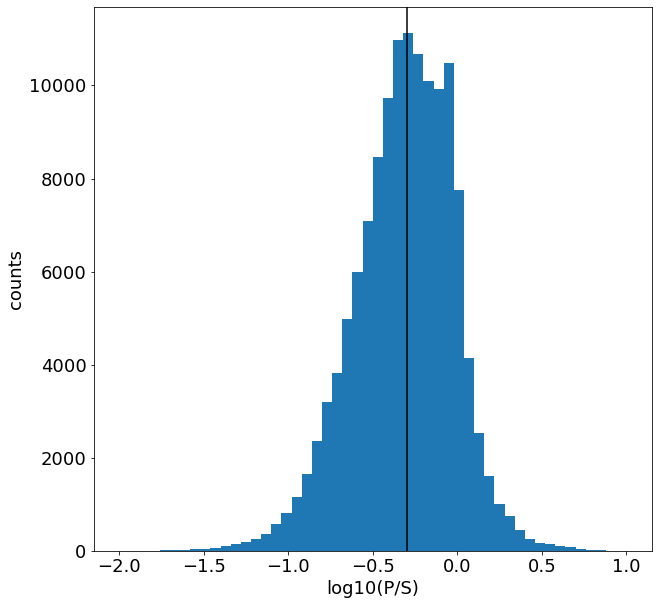

In [14]:
# Look at the distribution of P/S peak amplitude ratio
P_S_ratio = peak_ampliutde_P_all_flatten / peak_ampliutde_S_all_flatten
print(f'Median: {np.nanmedian(P_S_ratio)}')

fig, ax = plt.subplots(figsize=(10, 10))
ax.hist(np.log10(P_S_ratio), range=(-2, 1), bins=50)
ax.axvline(x=np.log10(np.nanmedian(P_S_ratio)), zorder=10, color='k')
ax.set_xlabel('log10(P/S)')
ax.set_ylabel('counts')
plt.savefig(results_output_dir + '/peak_strain_rate_P_S_ratio.png', bbox_inches='tight')

### Notes on the linear regression

```python
# Example of a linear fit using sklearn
from sklearn.linear_model import LinearRegression
X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
# y = 1 * x_0 + 2 * x_1 + 3
y = np.dot(X, np.array([1, 2])) + 3
reg = LinearRegression().fit(X, y)
reg.score(X, y)
```

```python
# Example of a linear fit using statsmodels package
import statsmodels.api as sm
X = sm.add_constant(X) # If the intercept is needed
reg = sm.OLS(y, X).fit()
print(reg.summary())

parameters = reg.params()

y_predict = reg.predict(X)

# Using smf (a simpler way)
import statsmodels.formula.api as smf
peak_amplitude_df = peak_amplitude_df.dropna()

regP = smf.ols(formula='np.log10(peak_P) ~ magnitude + np.log10(distance_in_km)',
                 data=peak_amplitude_df).fit()

# With the site term. Here -1 is necessary to force the intercept to be 0
regP_2 = smf.ols(formula='np.log10(peak_P) ~ magnitude + np.log10(distance_in_km) + C(channel_id) - 1', data=peak_amplitude_df).fit()

```

Save and load the regression results using statsmodels

```python
import statsmodels.api as sm
# Save
model.save(regression_results_dir + "/regression_results.pickle")
# Load
model = sm.load(regression_results_dir + "/regression_results.pickle")
print(model.summary())
```

### Regression 1. Linear regression on the data point (this regression ignores the different site responses)

To fit a linear relation (a, b and c) of $M$ (magnitude), $log_{10}D$ (distance) to $log_{10}E$ (peak amplitude), the constant intercept $c$ includes all other contributions

$log_{10}(E) = aM + blog_{10}D + c$

In [15]:
import statsmodels.formula.api as smf
peak_amplitude_df = peak_amplitude_df.dropna()

regP_1 = smf.ols(formula='np.log10(peak_P) ~ magnitude + np.log10(distance_in_km)', data=peak_amplitude_df).fit()
regS_1 = smf.ols(formula='np.log10(peak_S) ~ magnitude + np.log10(distance_in_km)', data=peak_amplitude_df).fit()

print(regP_1.summary())
print('\n\n')
print(regS_1.summary())

regP_1.save(regression_results_dir + "/P_regression_all_events_no_site_terms.pickle")
regS_1.save(regression_results_dir + "/S_regression_all_events_no_site_terms.pickle")

                            OLS Regression Results                            
Dep. Variable:       np.log10(peak_P)   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                 2.463e+05
Date:                Fri, 18 Mar 2022   Prob (F-statistic):               0.00
Time:                        10:22:26   Log-Likelihood:                -62211.
No. Observations:              133506   AIC:                         1.244e+05
Df Residuals:                  133503   BIC:                         1.245e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [16]:
# make prediciton and compare with the measured
y_P_predict_1 = regP_1.predict(peak_amplitude_df)
y_S_predict_1 = regS_1.predict(peak_amplitude_df)

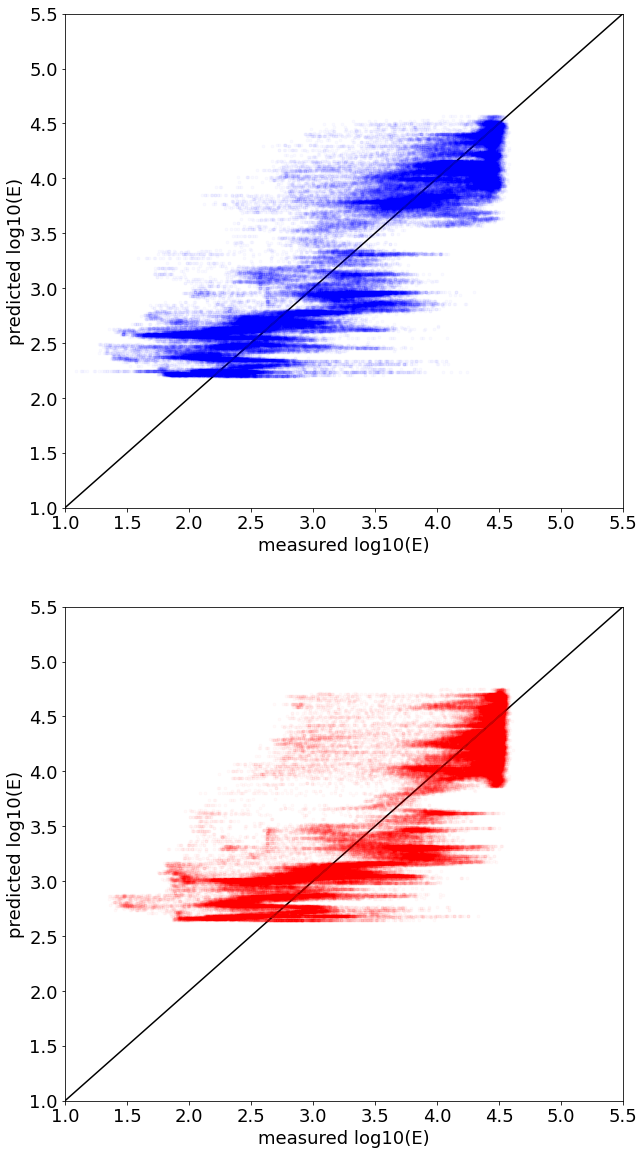

In [17]:
# Ground truth values
y_P = np.log10(peak_amplitude_df.peak_P)
y_S = np.log10(peak_amplitude_df.peak_S)

fig, ax = plt.subplots(2, 1, figsize=(10, 20), sharex=True, sharey=True)

ax[0].plot([0, 10], [0, 10], '-k', zorder=1)
ax[0].plot(y_P, y_P_predict_1, 'b.', alpha=0.02)
ax[0].set_ylabel('predicted log10(E)')
ax[0].set_xlabel('measured log10(E)')
ax[0].xaxis.set_tick_params(which='both',labelbottom=True)

ax[1].plot([0, 10], [0, 10], '-k', zorder=1)
ax[1].plot(y_S, y_S_predict_1, 'r.', alpha=0.02)
ax[1].set_ylabel('predicted log10(E)')
ax[1].set_xlabel('measured log10(E)')

ax[1].set_xlim(1., 5.5)
ax[1].set_ylim(1., 5.5)

plt.savefig(regression_results_dir + '/validate_predicted_strain_rate_all_events_no_site_terms.png', bbox_inches='tight')

### Regression 2: Linear regression on the data point including the site term

To fit a linear relation (a, b and $K_s$) of $M$ (magnitude), $log_{10}D$ (distance) to $log_{10}E$ (peak amplitude), $K_s$ is a channel specific term to be fitted. Subscript $s$ here corresponds to $s^{th}$ channel.

So now there are in total (2 + # of channels) parameters to fit. 

$log_{10}(E_s) = aM + blog_{10}D + K_s$

In [18]:
regP_2 = smf.ols(formula='np.log10(peak_P) ~ magnitude + np.log10(distance_in_km) + C(channel_id) - 1', data=peak_amplitude_df).fit()
regS_2 = smf.ols(formula='np.log10(peak_S) ~ magnitude + np.log10(distance_in_km) + C(channel_id) - 1', data=peak_amplitude_df).fit()

print(regP_2.params[-2:])
print('\n\n')
print(regS_2.params[-2:])

regP_2.save(regression_results_dir + "/P_regression_all_events_with_site_terms.pickle")
regS_2.save(regression_results_dir + "/S_regression_all_events_with_site_terms.pickle")

magnitude                   0.590782
np.log10(distance_in_km)   -1.569529
dtype: float64



magnitude                   0.558921
np.log10(distance_in_km)   -1.388479
dtype: float64


In [19]:
# make prediciton and compare with the measured
y_P_predict_2 = regP_2.predict(peak_amplitude_df)
y_S_predict_2 = regS_2.predict(peak_amplitude_df)

### First check the fitted site responses

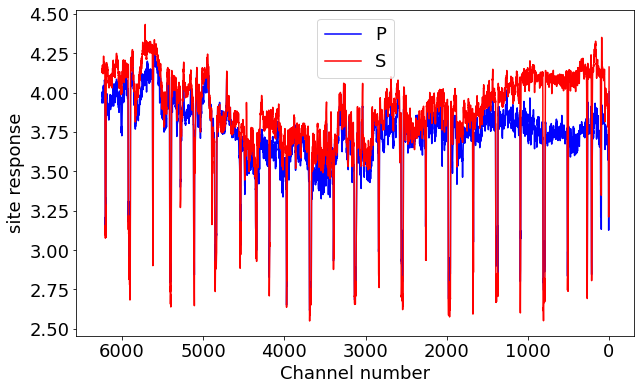

In [22]:
fig, ax = plt.subplots(figsize=(10, 6), sharex=True)
ax.plot(np.array(regP_2.params[:-2]), 'b', label='P')
ax.plot(np.array(regS_2.params[:-2]), 'r', label='S')

ax.invert_xaxis()
#ax.set_ylim(1, 4)
ax.legend()
ax.set_xlabel('Channel number')
ax.set_ylabel('site response')
plt.savefig(regression_results_dir + '/all_events_site_terms.png', bbox_inches='tight')

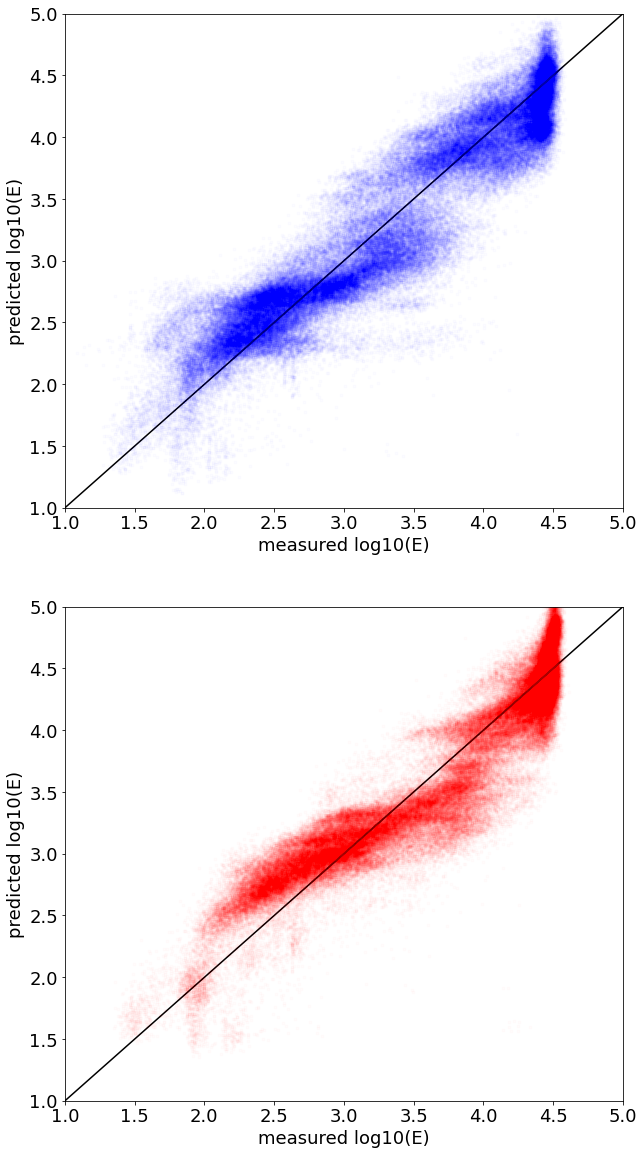

In [24]:
# Ground truth values
y_P = np.log10(peak_amplitude_df.peak_P)
y_S = np.log10(peak_amplitude_df.peak_S)


fig, ax = plt.subplots(2, 1, figsize=(10, 20), sharex=True, sharey=True)

ax[0].plot([0, 10], [0, 10], '-k', zorder=1)
ax[0].plot(y_P, y_P_predict_2, 'b.', alpha=0.01)
ax[0].set_ylabel('predicted log10(E)')
ax[0].set_xlabel('measured log10(E)')
ax[0].xaxis.set_tick_params(which='both',labelbottom=True)

ax[1].plot([0, 10], [0, 10], '-k', zorder=1)
ax[1].plot(y_S, y_S_predict_2, 'r.', alpha=0.01)
ax[1].set_ylabel('predicted log10(E)')
ax[1].set_xlabel('measured log10(E)')

ax[1].set_xlim(1., 5)
ax[1].set_ylim(1., 5)
plt.savefig(regression_results_dir + '/validate_predicted_strain_rate_all_events_with_site_terms.png', bbox_inches='tight')